### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

UsageError: Line magic function `%` not found.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [4]:
data = read_text("spa-eng\spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [5]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [6]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest.', 'Agradezco tu interés.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [7]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [8]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest', 'Agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [9]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [10]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['i appreciate all your help', 'aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['i appreciate your interest', 'agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [11]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


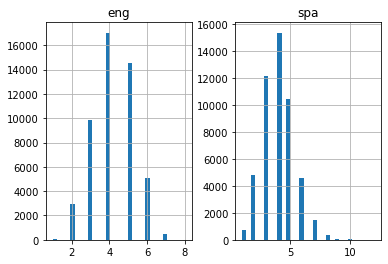

In [13]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [16]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [ ]:
print(spa_tokenizer.word_counts)

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [20]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [21]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [22]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [23]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/   If you try to force these pieces of the encoder-decoder together, you get an error indicating that the output of the decoder is 2D and 3D input to the decoder is required.

We can solve this using a RepeatVector layer. This layer simply repeats the provided 2D input multiple times to create a 3D output.

The RepeatVector layer can be used like an adapter to fit the encoder and decoder parts of the network together. We can configure the RepeatVector to repeat the fixed length vector one time for each time step in the output sequence.



To summarize, the RepeatVector is used as an **adapter to fit the fixed-sized 2D output of the encoder to the differing length and 3D input expected by the decoder**. The TimeDistributed wrapper allows the same output layer to be reused for each element in the output sequence.                              


In [ ]:
#################################################### DO NOT RUN IT (example of RepeatVector)
model = Sequential()
model.add(Dense(32, input_dim=32))
#### now: model.output_shape == (None, 32)
# note: `None` is the batch dimension
model.add(RepeatVector(3))
# now: model.output_shape == (None, 3, 32)

In the above example, the RepeatVector layer repeats the incoming inputs a specific number of time. The shape of the input in the above example was ( 32 , ). But the output shape of the RepeatVector was ( 3 , 32 ), since the inputs were repeated 3 times.

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [25]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


In [26]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['acc'])

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [27]:
filename = 'model.h1.LSTM'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 256s 4s/step - loss: 4.8403 - acc: 0.4509 - val_loss: 3.4188 - val_acc: 0.5041

Epoch 00001: val_loss improved from inf to 3.41884, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 2/30
63/63 [==============================] - 222s 4s/step - loss: 3.2569 - acc: 0.5102 - val_loss: 3.2091 - val_acc: 0.5100

Epoch 00002: val_loss improved from 3.41884 to 3.20912, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 3/30
63/63 [==============================] - 252s 4s/step - loss: 3.1096 - acc: 0.5185 - val_loss: 3.0754 - val_acc: 0.5287

Epoch 00003: val_loss improved from 3.20912 to 3.07544, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 4/30
63/63 [==============================] - 225s 4s/step - loss: 2.9592 - acc: 0.5318 - val_loss: 2.9751 - val_acc: 0.5422

Epoch 00004: val_loss improved from 3.07544 to 2.97515, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 5/30
63/63 [==============================] - 255s 4s/step - loss: 2.8164 - acc: 0.5496 - val_loss: 2.8301 - val_acc: 0.5595

Epoch 00005: val_loss improved from 2.97515 to 2.83007, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 6/30
63/63 [==============================] - 288s 5s/step - loss: 2.6497 - acc: 0.5666 - val_loss: 2.7088 - val_acc: 0.5726

Epoch 00006: val_loss improved from 2.83007 to 2.70881, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 7/30
63/63 [==============================] - 310s 5s/step - loss: 2.4992 - acc: 0.5828 - val_loss: 2.6356 - val_acc: 0.5869

Epoch 00007: val_loss improved from 2.70881 to 2.63565, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 8/30
63/63 [==============================] - 330s 5s/step - loss: 2.3459 - acc: 0.6001 - val_loss: 2.4947 - val_acc: 0.6020

Epoch 00008: val_loss improved from 2.63565 to 2.49474, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 9/30
63/63 [==============================] - 346s 6s/step - loss: 2.2068 - acc: 0.6152 - val_loss: 2.4433 - val_acc: 0.6090

Epoch 00009: val_loss improved from 2.49474 to 2.44325, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 10/30
63/63 [==============================] - 303s 5s/step - loss: 2.0885 - acc: 0.6276 - val_loss: 2.3538 - val_acc: 0.6190

Epoch 00010: val_loss improved from 2.44325 to 2.35385, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 11/30
63/63 [==============================] - 295s 5s/step - loss: 1.9706 - acc: 0.6394 - val_loss: 2.2668 - val_acc: 0.6306

Epoch 00011: val_loss improved from 2.35385 to 2.26676, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 12/30
63/63 [==============================] - 290s 5s/step - loss: 1.8536 - acc: 0.6524 - val_loss: 2.2146 - val_acc: 0.6370

Epoch 00012: val_loss improved from 2.26676 to 2.21457, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 13/30
63/63 [==============================] - 160s 3s/step - loss: 1.7500 - acc: 0.6645 - val_loss: 2.1959 - val_acc: 0.6415

Epoch 00013: val_loss improved from 2.21457 to 2.19593, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 14/30
63/63 [==============================] - 164s 3s/step - loss: 1.6601 - acc: 0.6755 - val_loss: 2.1190 - val_acc: 0.6506

Epoch 00014: val_loss improved from 2.19593 to 2.11899, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 15/30
63/63 [==============================] - 183s 3s/step - loss: 1.5588 - acc: 0.6894 - val_loss: 2.0657 - val_acc: 0.6571

Epoch 00015: val_loss improved from 2.11899 to 2.06574, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 16/30
63/63 [==============================] - 206s 3s/step - loss: 1.4698 - acc: 0.7000 - val_loss: 2.0370 - val_acc: 0.6635

Epoch 00016: val_loss improved from 2.06574 to 2.03702, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 17/30
63/63 [==============================] - 219s 3s/step - loss: 1.3833 - acc: 0.7126 - val_loss: 1.9962 - val_acc: 0.6693

Epoch 00017: val_loss improved from 2.03702 to 1.99624, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 18/30
63/63 [==============================] - 240s 4s/step - loss: 1.2890 - acc: 0.7275 - val_loss: 1.9819 - val_acc: 0.6667

Epoch 00018: val_loss improved from 1.99624 to 1.98195, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 19/30
63/63 [==============================] - 237s 4s/step - loss: 1.2155 - acc: 0.7387 - val_loss: 1.9346 - val_acc: 0.6796

Epoch 00019: val_loss improved from 1.98195 to 1.93456, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 20/30
63/63 [==============================] - 224s 4s/step - loss: 1.1363 - acc: 0.7519 - val_loss: 1.9134 - val_acc: 0.6792

Epoch 00020: val_loss improved from 1.93456 to 1.91335, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 21/30
63/63 [==============================] - 206s 3s/step - loss: 1.0614 - acc: 0.7656 - val_loss: 1.8950 - val_acc: 0.6864

Epoch 00021: val_loss improved from 1.91335 to 1.89495, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 22/30
63/63 [==============================] - 190s 3s/step - loss: 0.9873 - acc: 0.7786 - val_loss: 1.8580 - val_acc: 0.6894

Epoch 00022: val_loss improved from 1.89495 to 1.85802, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 23/30
63/63 [==============================] - 253s 4s/step - loss: 0.9200 - acc: 0.7925 - val_loss: 1.8389 - val_acc: 0.6930

Epoch 00023: val_loss improved from 1.85802 to 1.83887, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 24/30
63/63 [==============================] - 165s 3s/step - loss: 0.8588 - acc: 0.8044 - val_loss: 1.8488 - val_acc: 0.6967

Epoch 00024: val_loss did not improve from 1.83887
Epoch 25/30
63/63 [==============================] - 273s 4s/step - loss: 0.8000 - acc: 0.8172 - val_loss: 1.8122 - val_acc: 0.6970

Epoch 00025: val_loss improved from 1.83887 to 1.81224, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 26/30
63/63 [==============================] - 261s 4s/step - loss: 0.7325 - acc: 0.8314 - val_loss: 1.8036 - val_acc: 0.6994

Epoch 00026: val_loss improved from 1.81224 to 1.80364, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 27/30
63/63 [==============================] - 141s 2s/step - loss: 0.6862 - acc: 0.8423 - val_loss: 1.8000 - val_acc: 0.7024

Epoch 00027: val_loss improved from 1.80364 to 1.80005, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 28/30
63/63 [==============================] - 147s 2s/step - loss: 0.6317 - acc: 0.8554 - val_loss: 1.8344 - val_acc: 0.7041

Epoch 00028: val_loss did not improve from 1.80005
Epoch 29/30
63/63 [==============================] - 158s 3s/step - loss: 0.5851 - acc: 0.8662 - val_loss: 1.7977 - val_acc: 0.7069

Epoch 00029: val_loss improved from 1.80005 to 1.79772, saving model to model.h1.LSTM


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


INFO:tensorflow:Assets written to: model.h1.LSTM\assets


Epoch 30/30
63/63 [==============================] - 135s 2s/step - loss: 0.5362 - acc: 0.8772 - val_loss: 1.8010 - val_acc: 0.7092

Epoch 00030: val_loss did not improve from 1.79772


Let's compare the training loss and the validation loss.

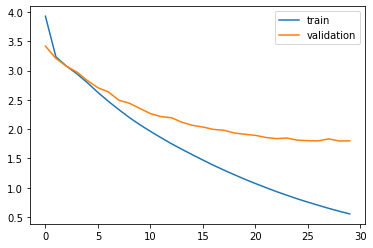

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

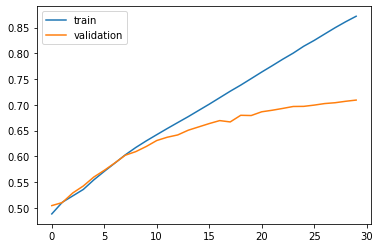

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [31]:
model = load_model('model.h1.LSTM')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\raulg\anaconda3\envs\ADNE\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [39]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [40]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [41]:
pd.set_option('display.max_colwidth', 200)

In [42]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,theyre very
1,i know tom,i know tom
2,you may refuse,you may return
3,thats private,thats is nonsense
4,tom leaped from his seat,tom jumped his
5,have you ever sold a car,dont you have a car
6,how many kids do you have,how many books do you have
7,i will not let you do it,i wont do you
8,isnt it beautiful,isnt it sweet
9,my parrot died yesterday,my wife was


In [43]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,did tom know help
9986,tom can be clumsy,tom might be
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who it was
9989,shes also a beauty,its a beauty
9990,i love your daughter,i want your shirt
9991,he teaches english,he stopped to cry
9992,i overslept,i was asleep
9993,he is as poor as can be,he is as
9994,wheres my shirt,wheres my brother


In [44]:
pred_df.sample(15)

,actual,predicted
6232,well be leaving tomorrow,we come tomorrow
3866,tips are not accepted,dont doesnt no
7245,plastic boxes last longer,most carry wood rise
3022,am i disturbing you,did you hurt you
8434,thatll do,thatll do
9076,should i open the windows,should i open the window
808,go to school,go to
4631,they dont listen,they will listen to
4208,how much does tom weigh,how much did tom cost
7657,do you talk to your plants,are you talk to your


In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:
filename = 'model.h1.SimpleRNN'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 188s 3s/step - loss: 4.4755 - acc: 0.4488 - val_loss: 3.2714 - val_acc: 0.5195

Epoch 00001: val_loss improved from inf to 3.27143, saving model to model.h1.SimpleRNN
INFO:tensorflow:Assets written to: model.h1.SimpleRNN\assets
Epoch 2/30
63/63 [==============================] - 167s 3s/step - loss: 3.2166 - acc: 0.5230 - val_loss: 3.0378 - val_acc: 0.5435

Epoch 00002: val_loss improved from 3.27143 to 3.03785, saving model to model.h1.SimpleRNN
INFO:tensorflow:Assets written to: model.h1.SimpleRNN\assets
Epoch 3/30
63/63 [==============================] - 171s 3s/step - loss: 3.0893 - acc: 0.5413 - val_loss: 2.9043 - val_acc: 0.5599

Epoch 00003: val_loss improved from 3.03785 to 2.90426, saving model to model.h1.SimpleRNN
INFO:tensorflow:Assets written to: model.h1.SimpleRNN\assets
Epoch 4/30
63/63 [==============================] - 144s 2s/step - loss: 2.8267 - acc: 0.5607 - val_loss: 2.8016 - val_acc: 0.5718

Epoch 00004: val_los

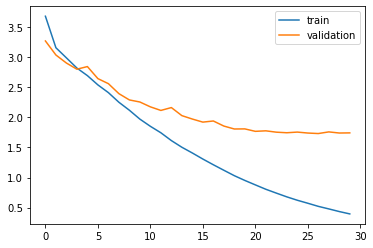

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

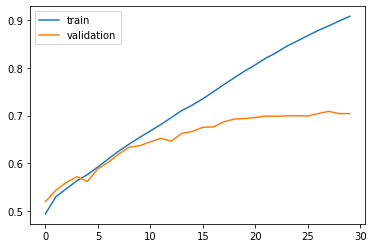

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

In [41]:
model = load_model('model.h1.SimpleRNN')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\raulg\anaconda3\envs\ADNE\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [44]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [45]:
pd.set_option('display.max_colwidth', 200)

In [46]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,they are very
1,i know tom,i know what tom
2,you may refuse,you can answer
3,thats private,thats is
4,tom leaped from his seat,tom set up his room
5,have you ever sold a car,did you get me a car
6,how many kids do you have,how many kids do you have
7,i will not let you do it,i wont not you it
8,isnt it beautiful,isnt it beautiful
9,my parrot died yesterday,my father was yesterday


In [47]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,tom talk mary
9986,tom can be clumsy,tom can be a
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who it was
9989,shes also a beauty,shes is beauty
9990,i love your daughter,i want to hair
9991,he teaches english,he study english
9992,i overslept,i fell asleep
9993,he is as poor as can be,he is as
9994,wheres my shirt,wheres is my


In [48]:
pred_df.sample(15)

,actual,predicted
6431,please sit here,please sit here
8020,i have a book in my hand,i have a on hand
7920,ive never seen a rainbow,i never seen
6400,tom wants to change,tom wants to change
2480,well toss for it,well of up in a
9146,how thrilling,how hair
3363,he is depressed,he is depressed
7815,tom is working there,tom is here
184,i love surprise parties,i love parties
8603,this is extraordinary,this is disgusting


In [27]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [30]:
filename = 'model.h1.GRU'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 252s 4s/step - loss: 4.7101 - acc: 0.4503 - val_loss: 3.3144 - val_acc: 0.5102

Epoch 00001: val_loss improved from inf to 3.31440, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 2/30
63/63 [==============================] - 205s 3s/step - loss: 3.2130 - acc: 0.5141 - val_loss: 3.2552 - val_acc: 0.5140

Epoch 00002: val_loss improved from 3.31440 to 3.25516, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 3/30
63/63 [==============================] - 200s 3s/step - loss: 3.0427 - acc: 0.5264 - val_loss: 3.0174 - val_acc: 0.5363

Epoch 00003: val_loss improved from 3.25516 to 3.01745, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 4/30
63/63 [==============================] - 206s 3s/step - loss: 2.8683 - acc: 0.5461 - val_loss: 2.8927 - val_acc: 0.5535

Epoch 00004: val_loss improved from 3.01745 to 2.89271, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 5/30
63/63 [==============================] - 231s 4s/step - loss: 2.7030 - acc: 0.5610 - val_loss: 2.7475 - val_acc: 0.5664

Epoch 00005: val_loss improved from 2.89271 to 2.74753, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 6/30
63/63 [==============================] - 278s 4s/step - loss: 2.5261 - acc: 0.5782 - val_loss: 2.6029 - val_acc: 0.5849

Epoch 00006: val_loss improved from 2.74753 to 2.60287, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 7/30
63/63 [==============================] - 279s 4s/step - loss: 2.3538 - acc: 0.5983 - val_loss: 2.4710 - val_acc: 0.6020

Epoch 00007: val_loss improved from 2.60287 to 2.47102, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 8/30
63/63 [==============================] - 300s 5s/step - loss: 2.1822 - acc: 0.6170 - val_loss: 2.3718 - val_acc: 0.6155

Epoch 00008: val_loss improved from 2.47102 to 2.37185, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 9/30
63/63 [==============================] - 322s 5s/step - loss: 2.0213 - acc: 0.6348 - val_loss: 2.2542 - val_acc: 0.6302

Epoch 00009: val_loss improved from 2.37185 to 2.25423, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 10/30
63/63 [==============================] - 294s 5s/step - loss: 1.8732 - acc: 0.6544 - val_loss: 2.1763 - val_acc: 0.6417

Epoch 00010: val_loss improved from 2.25423 to 2.17634, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 11/30
63/63 [==============================] - 278s 4s/step - loss: 1.7363 - acc: 0.6709 - val_loss: 2.1117 - val_acc: 0.6498

Epoch 00011: val_loss improved from 2.17634 to 2.11168, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 12/30
63/63 [==============================] - 247s 4s/step - loss: 1.6134 - acc: 0.6854 - val_loss: 2.0696 - val_acc: 0.6562

Epoch 00012: val_loss improved from 2.11168 to 2.06958, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 13/30
63/63 [==============================] - 208s 3s/step - loss: 1.4917 - acc: 0.7019 - val_loss: 2.0005 - val_acc: 0.6654

Epoch 00013: val_loss improved from 2.06958 to 2.00048, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 14/30
63/63 [==============================] - 129s 2s/step - loss: 1.3846 - acc: 0.7170 - val_loss: 1.9399 - val_acc: 0.6736

Epoch 00014: val_loss improved from 2.00048 to 1.93987, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 15/30
63/63 [==============================] - 148s 2s/step - loss: 1.2934 - acc: 0.7308 - val_loss: 1.8998 - val_acc: 0.6761

Epoch 00015: val_loss improved from 1.93987 to 1.89977, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 16/30
63/63 [==============================] - 167s 3s/step - loss: 1.1888 - acc: 0.7471 - val_loss: 1.8544 - val_acc: 0.6837

Epoch 00016: val_loss improved from 1.89977 to 1.85436, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 17/30
63/63 [==============================] - 189s 3s/step - loss: 1.1118 - acc: 0.7601 - val_loss: 1.8369 - val_acc: 0.6893

Epoch 00017: val_loss improved from 1.85436 to 1.83690, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 18/30
63/63 [==============================] - 207s 3s/step - loss: 1.0250 - acc: 0.7746 - val_loss: 1.7963 - val_acc: 0.6932

Epoch 00018: val_loss improved from 1.83690 to 1.79628, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 19/30
63/63 [==============================] - 225s 4s/step - loss: 0.9419 - acc: 0.7916 - val_loss: 1.7724 - val_acc: 0.6968

Epoch 00019: val_loss improved from 1.79628 to 1.77236, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 20/30
63/63 [==============================] - 227s 4s/step - loss: 0.8680 - acc: 0.8059 - val_loss: 1.7722 - val_acc: 0.6997

Epoch 00020: val_loss improved from 1.77236 to 1.77223, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 21/30
63/63 [==============================] - 212s 3s/step - loss: 0.7956 - acc: 0.8207 - val_loss: 1.7589 - val_acc: 0.7034

Epoch 00021: val_loss improved from 1.77223 to 1.75889, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 22/30
63/63 [==============================] - 194s 3s/step - loss: 0.7389 - acc: 0.8314 - val_loss: 1.7388 - val_acc: 0.7061

Epoch 00022: val_loss improved from 1.75889 to 1.73884, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 23/30
63/63 [==============================] - 175s 3s/step - loss: 0.6752 - acc: 0.8446 - val_loss: 1.7229 - val_acc: 0.7084

Epoch 00023: val_loss improved from 1.73884 to 1.72291, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 24/30
63/63 [==============================] - 154s 2s/step - loss: 0.6139 - acc: 0.8602 - val_loss: 1.7366 - val_acc: 0.7031

Epoch 00024: val_loss did not improve from 1.72291
Epoch 25/30
63/63 [==============================] - 206s 3s/step - loss: 0.5632 - acc: 0.8712 - val_loss: 1.7318 - val_acc: 0.7132

Epoch 00025: val_loss did not improve from 1.72291
Epoch 26/30
63/63 [==============================] - 139s 2s/step - loss: 0.5140 - acc: 0.8839 - val_loss: 1.7169 - val_acc: 0.7148

Epoch 00026: val_loss improved from 1.72291 to 1.71688, saving model to model.h1.GRU


INFO:tensorflow:Assets written to: model.h1.GRU\assets


INFO:tensorflow:Assets written to: model.h1.GRU\assets


Epoch 27/30
63/63 [==============================] - 228s 4s/step - loss: 0.4647 - acc: 0.8950 - val_loss: 1.7335 - val_acc: 0.7150

Epoch 00027: val_loss did not improve from 1.71688
Epoch 28/30
63/63 [==============================] - 163s 3s/step - loss: 0.4156 - acc: 0.9070 - val_loss: 1.7340 - val_acc: 0.7152

Epoch 00028: val_loss did not improve from 1.71688
Epoch 29/30
63/63 [==============================] - 210s 3s/step - loss: 0.3798 - acc: 0.9173 - val_loss: 1.7263 - val_acc: 0.7144

Epoch 00029: val_loss did not improve from 1.71688
Epoch 30/30
63/63 [==============================] - 166s 3s/step - loss: 0.3380 - acc: 0.9268 - val_loss: 1.7379 - val_acc: 0.7095

Epoch 00030: val_loss did not improve from 1.71688


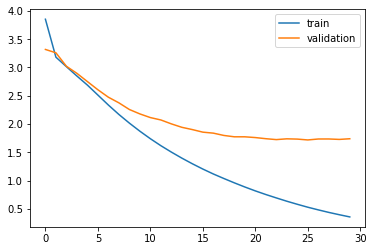

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

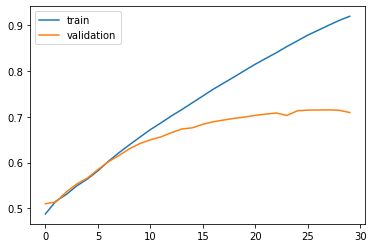

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

In [34]:
model = load_model('model.h1.GRU')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\raulg\anaconda3\envs\ADNE\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [37]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [38]:
pd.set_option('display.max_colwidth', 200)

In [39]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,they very
1,i know tom,i know tom
2,you may refuse,you can put it
3,thats private,thats is
4,tom leaped from his seat,tom put on his
5,have you ever sold a car,you ever a car
6,how many kids do you have,how many kids do you have
7,i will not let you do it,i wont let you do
8,isnt it beautiful,isnt it beautiful
9,my parrot died yesterday,my mother died back


In [40]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,does tom still know mary
9986,tom can be clumsy,tom might be fun
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who was
9989,shes also a beauty,hes is a beauty
9990,i love your daughter,i want your respect
9991,he teaches english,he english
9992,i overslept,i was asleep
9993,he is as poor as can be,he is like as a
9994,wheres my shirt,wheres my


In [41]:
pred_df.sample(15)

,actual,predicted
1629,tom said you were sick,tom said he was be
8338,we like tom,we want tom
7727,im thorough,im a
4924,who taught you that,who cares you that
1437,tokyo is a huge city,tokyo is a big city
3069,youre fired,youre are
1852,she sent him a message,he sent him a message
7495,sorry my mistake,im feel mine
3506,tom isnt at the hotel,tom isnt in the hotel
1905,arent you happy,you happy
